# SI 699: Project Phase 2

Refining features and models, and integrating external evaluation dataset.

### Setup

In [ ]:
!pip install nrclex

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=ef23cafe7e82acabb982d9ac41c349cb4b3ee3ce0ac6b9489f2407f02280f0ee
  Stored in directory: /root/.cache/pip/wheels/1f/e8/d0/e3c3da0ef3b37ef4381dbf5c9401f3a9861a63ce221b13d8bb
Successfully built nrclex


In [ ]:
import re
import spacy
import nltk
import torch
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from scipy.stats import ttest_ind
from matplotlib.patches import Patch
from nrclex import NRCLex
from nltk.corpus import wordnet as wn
from scipy.stats import pointbiserialr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay, accuracy_score, f1_score
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoTokenizer, AutoModelForTokenClassification, pipeline, AutoModelForSeq2SeqLM

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Data setup

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/sualehafarid/stories/refs/heads/main/hcV3-stories.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6854 entries, 0 to 6853
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AssignmentId       6854 non-null   object 
 1   WorkTimeInSeconds  6854 non-null   int64  
 2   WorkerId           6854 non-null   object 
 3   annotatorAge       6831 non-null   float64
 4   annotatorGender    6854 non-null   object 
 5   annotatorRace      6854 non-null   object 
 6   distracted         6854 non-null   float64
 7   draining           6854 non-null   float64
 8   frequency          4098 non-null   float64
 9   importance         6710 non-null   float64
 10  logTimeSinceEvent  6854 non-null   float64
 11  mainEvent          6854 non-null   object 
 12  memType            6854 non-null   object 
 13  mostSurprising     6854 non-null   object 
 14  openness           6854 non-null   float64
 15  recAgnPairId       2619 non-null   object 
 16  recImgPairId       5328 

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
WorkTimeInSeconds,6854.0,2.094556e+03,1.694784e+03,173.00000,924.250000,1526.00000,2678.500000,1.068000e+04
annotatorAge,6831.0,3.355351e+01,1.014654e+01,18.00000,25.000000,30.00000,40.000000,5.500000e+01
distracted,6854.0,1.416837e+00,8.908060e-01,1.00000,1.000000,1.00000,1.000000,5.000000e+00
draining,6854.0,2.182521e+00,1.310124e+00,1.00000,1.000000,2.00000,3.000000,5.000000e+00
frequency,4098.0,3.646413e+00,1.028357e+00,1.00000,3.000000,4.00000,4.000000,5.000000e+00
importance,6710.0,3.952608e+00,1.258208e+00,1.00000,3.000000,4.00000,5.000000,5.000000e+00
logTimeSinceEvent,6854.0,7.001817e+00,1.320011e+01,1.94591,3.555348,4.49981,5.010635,1.368181e+02
openness,6854.0,5.593996e-01,4.164938e-01,-1.00000,0.250000,0.62500,0.875000,1.000000e+00
similarity,2756.0,2.916546e+00,1.441768e+00,1.00000,2.000000,3.00000,4.000000,5.000000e+00
stressful,6854.0,2.168223e+00,1.325316e+00,1.00000,1.000000,2.00000,3.000000,5.000000e+00


In [ ]:
df.shape

(6854, 23)

In [ ]:
df.size

157642

In [ ]:
df.isna().mean().sort_values(ascending=False)

,0
recAgnPairId,0.617887
similarity,0.597899
similarityReason,0.597899
frequency,0.402101
recImgPairId,0.222644
importance,0.021010
annotatorAge,0.003356
distracted,0.000000
annotatorRace,0.000000
annotatorGender,0.000000


### Re-doing and Saving Features Engineered for CP1 to file


In [ ]:
# filter dataset
df = df[df["memType"].isin(["imagined", "recalled"])].copy()
df.shape

In [ ]:
# clean up the text

df["story_clean"] = df["story"].str.lower().str.replace(r"[^a-z\s]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df["tokens"] = df["story_clean"].str.split()

# token stats
df["n_tokens"] = df["tokens"].apply(len)
df["n_chars"] = df["story_clean"].str.len()

df[["memType","n_tokens","n_chars"]].describe().T

In [ ]:
# feature engineering and extraction

# first define word categories that may be helpful eg modal verbs
MODALS = {
    "might","could","maybe","possibly","perhaps","seems","seemed","appear","appears","appeared",
    "guess","guessing","likely","unlikely","probably","apparently","supposedly","presumably",
    "as","like","as if"
}

# define first vs third person lists
FIRST_PERSON = {"i","me","my","mine","myself"}
THIRD_PERSON = {"he","him","his","she","her","hers","they","them","their","theirs"}

In [ ]:
# create modal related features
df["modal"] = df["tokens"].apply(lambda x: len([w for w in x if w in MODALS]))
df["modal_rate"] = df["tokens"].apply(lambda x: sum(w in MODALS for w in x) / len(x) if len(x) > 0 else 0)

# get length feature
df["story_length"] = df["tokens"].apply(len)
df["summary_length"] = df["summary"].str.split().apply(len)

# first person pronoun rate (for more personal story telling style)
df["first_person_rate"] = df["tokens"].apply(lambda x: sum(w in FIRST_PERSON for w in x) / len(x) if len(x) > 0 else 0)

# third person pronoun rate (for detached storytelling style)
df["third_person_rate"] = df["tokens"].apply(lambda x: sum(w in THIRD_PERSON for w in x) / len(x) if len(x) > 0 else 0)

# sentiment feature
df["sentiment"] = df["story"].apply(lambda x: TextBlob(x).sentiment.polarity)

# subjectivity feature: 0 = factual/objective, 1 = highly personal/opinionated (imagined or hallucinated texts are often more subjective)
df["subjectivity"] = df["story"].apply(lambda x: TextBlob(x).sentiment.subjectivity)


In [ ]:
# save updated df with all the new features
df.to_csv('updated_data1.csv', index=False)

In [ ]:
features = df[["memType","modal","modal_rate","story_length","summary_length","first_person_rate","third_person_rate","sentiment","subjectivity"]]

summary = features.groupby("memType").agg(["mean","std","median","count"])
summary

### CP2 Work


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/sualehafarid/stories/refs/heads/main/updated_data1.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5535 entries, 0 to 5534
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AssignmentId       5535 non-null   object 
 1   WorkTimeInSeconds  5535 non-null   int64  
 2   WorkerId           5535 non-null   object 
 3   annotatorAge       5518 non-null   float64
 4   annotatorGender    5535 non-null   object 
 5   annotatorRace      5535 non-null   object 
 6   distracted         5535 non-null   float64
 7   draining           5535 non-null   float64
 8   frequency          2779 non-null   float64
 9   importance         5391 non-null   float64
 10  logTimeSinceEvent  5535 non-null   float64
 11  mainEvent          5535 non-null   object 
 12  memType            5535 non-null   object 
 13  mostSurprising     5535 non-null   object 
 14  openness           5535 non-null   float64
 15  recAgnPairId       1309 non-null   object 
 16  recImgPairId       5328 

#### Features Based on Feedback

In [ ]:
# df = pd.read_csv("https://raw.githubusercontent.com/sualehafarid/stories/refs/heads/main/updated_data2.csv")

In [ ]:
nlp = spacy.load("en_core_web_sm")

def speculativeness(text):
    doc = nlp(text)
    modal_like = [tok for tok in doc if tok.tag_ in ["MD"] or tok.dep_ in ["advcl", "ccomp"]]
    return len(modal_like) / len(doc)

df["speculativeness"] = df["story_clean"].apply(speculativeness)

In [ ]:
def emotional_expressivity(text):
    emotion_scores = NRCLex(text).raw_emotion_scores
    n_tokens = len(nltk.word_tokenize(text))
    n_emotions = len(emotion_scores)
    total_emotion_words = sum(emotion_scores.values())
    intensity = total_emotion_words / (n_tokens or 1)
    return n_emotions, intensity

df["n_emotions"], df["emotion_intensity"] = zip(*df["story_clean"].map(emotional_expressivity))

In [ ]:
def syntactic_complexity(text):
    doc = nlp(text)
    depths = [len([tok for tok in sent if tok.dep_ in ["advcl", "ccomp", "relcl"]]) for sent in doc.sents]
    return sum(depths)/len(list(doc.sents))

df["syntactic_complexity"] = df["story_clean"].apply(syntactic_complexity)

##### Plot distributions and correlations to see how effective these measures are

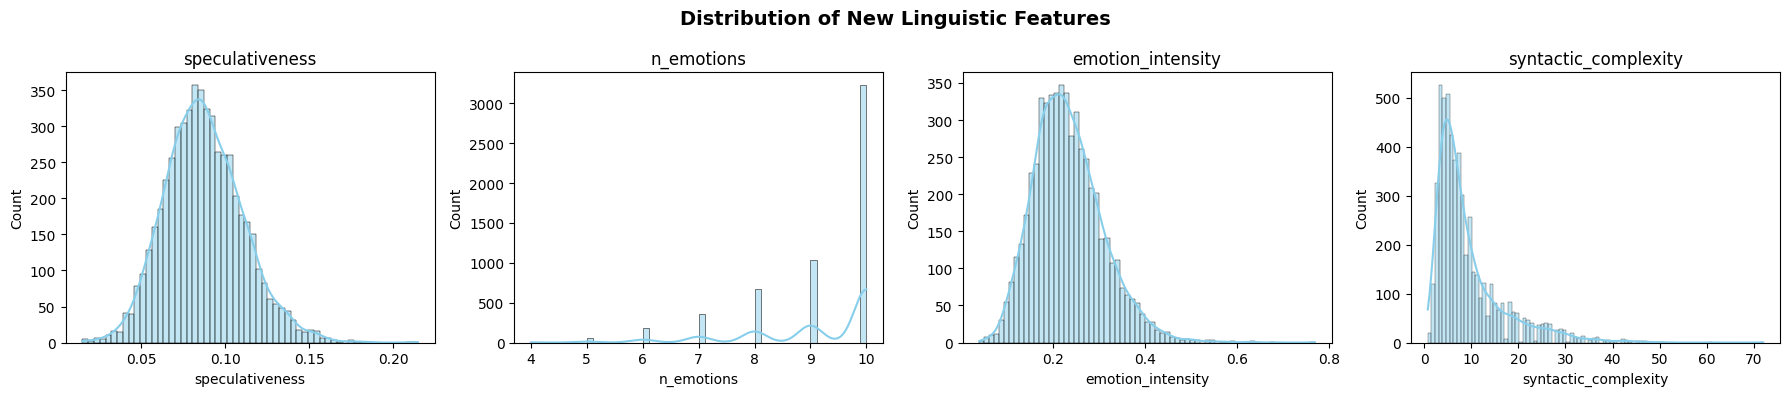

In [ ]:
new_feats = ["speculativeness", "n_emotions", "emotion_intensity", "syntactic_complexity"]

# distributions
fig, axes = plt.subplots(1, len(new_feats), figsize=(18, 4))
for ax, feat in zip(axes, new_feats):
    sns.histplot(df[feat].dropna(), kde=True, ax=ax, color="skyblue")
    ax.set_title(feat)
plt.suptitle("Distribution of New Linguistic Features", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

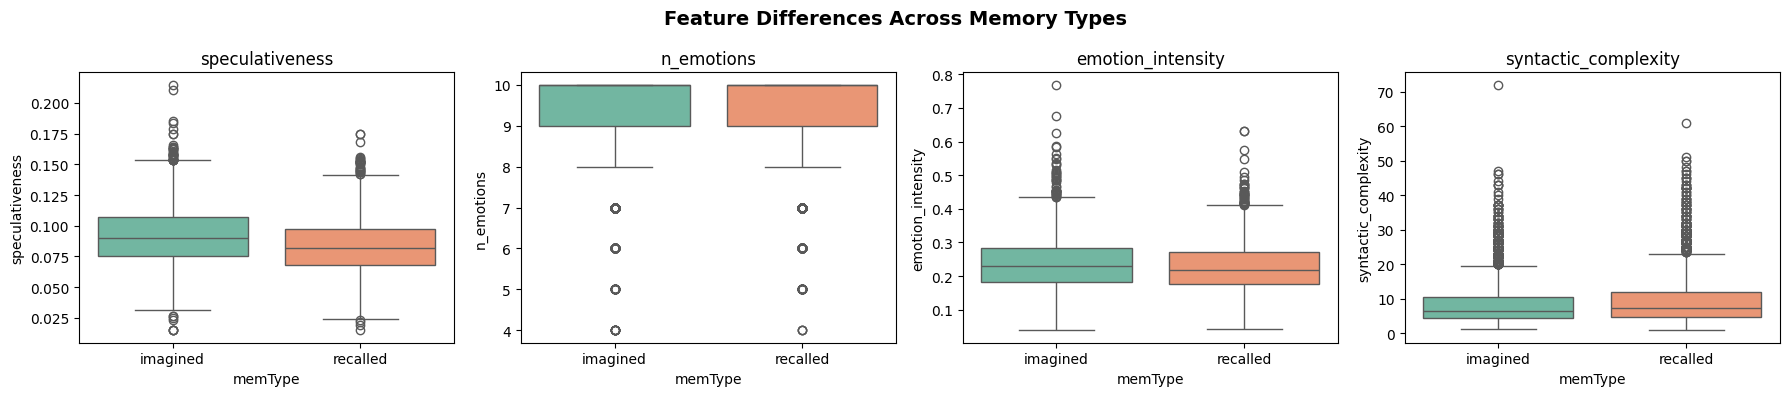

In [ ]:
# compare between recalled and imagined
fig, axes = plt.subplots(1, len(new_feats), figsize=(18, 4))
for ax, feat in zip(axes, new_feats):
    sns.boxplot(data=df, x="memType", y=feat, hue="memType", palette="Set2", legend=False, ax=ax)
    ax.set_title(feat)

plt.suptitle("Feature Differences Across Memory Types", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

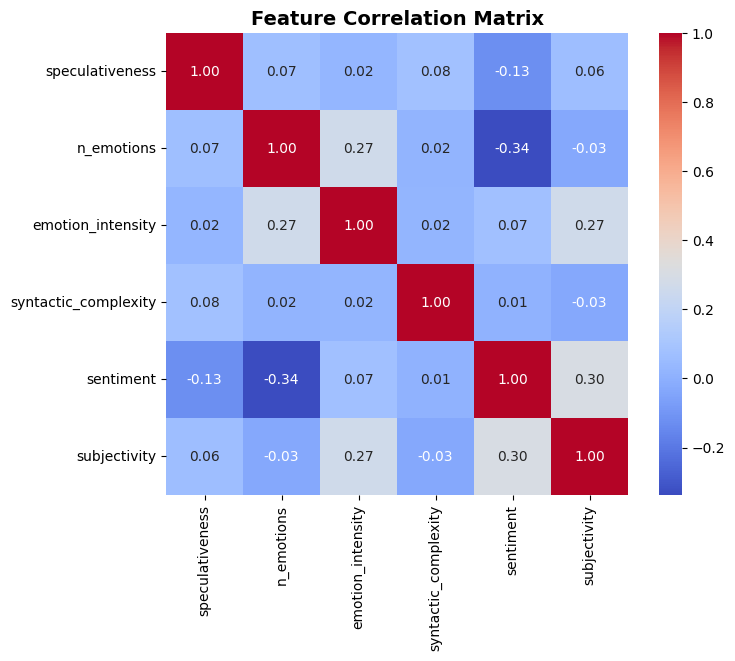

In [ ]:
# correlations
corr = df[new_feats + ["sentiment", "subjectivity"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix", fontsize=14, weight="bold")
plt.show()

Correlation of new features with memType (1=imagined, 0=recalled):


,feature,r,p_value
0,speculativeness,0.172710,0.000000
2,emotion_intensity,0.063529,0.000002
1,n_emotions,0.000178,0.989450
3,syntactic_complexity,-0.074429,0.000000


/tmp/ipython-input-1452996241.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_df, x="r", y="feature", palette="coolwarm", orient="h")


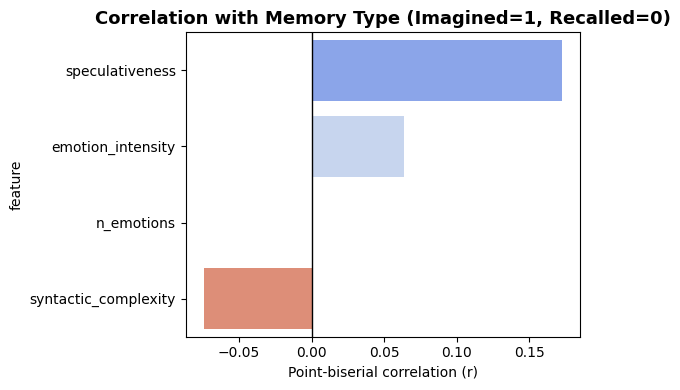

In [ ]:
## chek how well these features correlate with memtype and so how useful for my analysis
# Encode memtype to be numeric
df["memType_num"] = df["memType"].map({"imagined": 1, "recalled": 0})

# Compute point-biserial correlations
corrs = []
for feat in new_feats:
    valid = df[[feat, "memType_num"]].dropna()
    r, p = pointbiserialr(valid["memType_num"], valid[feat])
    corrs.append({"feature": feat, "r": r, "p_value": p})

corr_df = pd.DataFrame(corrs).sort_values("r", ascending=False)

# Display correlation table ---
print("Correlation of new features with memType (1=imagined, 0=recalled):")
display(corr_df.style.background_gradient(subset=["r"], cmap="coolwarm", vmin=-1, vmax=1))

# Plot correlation strengths ---
plt.figure(figsize=(6,4))
sns.barplot(data=corr_df, x="r", y="feature", palette="coolwarm", orient="h")
plt.axvline(0, color="black", lw=1)
plt.title("Correlation with Memory Type (Imagined=1, Recalled=0)", fontsize=13, weight="bold")
plt.xlabel("Point-biserial correlation (r)")
plt.tight_layout()
plt.show()


In [ ]:
# group means
print(df.groupby("memType")[new_feats].mean().round(3))

          speculativeness  n_emotions  emotion_intensity  syntactic_complexity
memType                                                                       
imagined            0.091       9.182              0.237                 8.800
recalled            0.083       9.182              0.228                 9.908


#### Features Based on Sap et al. (2020)

In [ ]:
conc = pd.read_csv("https://raw.githubusercontent.com/bodowinter/good_metaphors/refs/heads/master/data/brysbaert_2014_concreteness.csv")
conc_dict = dict(zip(conc["Word"].str.lower(), conc["Conc.M"]))

def avg_concreteness(text):
    import numpy as np
    doc = nlp(text.lower())
    scores = [conc_dict.get(tok.lemma_, None) for tok in doc if tok.is_alpha]
    scores = [s for s in scores if s is not None]
    return np.mean(scores) if scores else None

df["concreteness_mean"] = df["story_clean"].apply(avg_concreteness)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

def avg_perplexity(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        loss = model(**inputs, labels=inputs["input_ids"]).loss
    return torch.exp(loss).item()

df["narrative_flow"] = df["story_clean"].apply(avg_perplexity)

In [ ]:
def realis_density(text):
    doc = nlp(text)
    realis = 0
    for token in doc:
        if token.pos_ == "VERB" and token.morph.get("VerbForm") == ["Fin"] and not any(t.tag_=="MD" for t in token.children):
            realis += 1
    return realis / len(list(doc.sents))

df["realis_density"] = df["story_clean"].apply(realis_density)

In [ ]:
def commonsense_density(text):
    doc = nlp(text)
    triples = [tok for tok in doc if tok.dep_=="ROOT" and wn.synsets(tok.lemma_)]
    return len(triples)/len(list(doc.sents))

df["commonsense_density"] = df["story_clean"].apply(commonsense_density)

In [ ]:
def event_density(text):
    doc = nlp(text)
    verbs = [t for t in doc if t.pos_ == "VERB"]
    return len(verbs) / len(list(doc.sents))

df["event_density"] = df["story_clean"].apply(event_density)

##### Look at distributions and correlations of paper features

In [ ]:
paper_feats = ["concreteness_mean", "narrative_flow", "realis_density","commonsense_density", "event_density"]

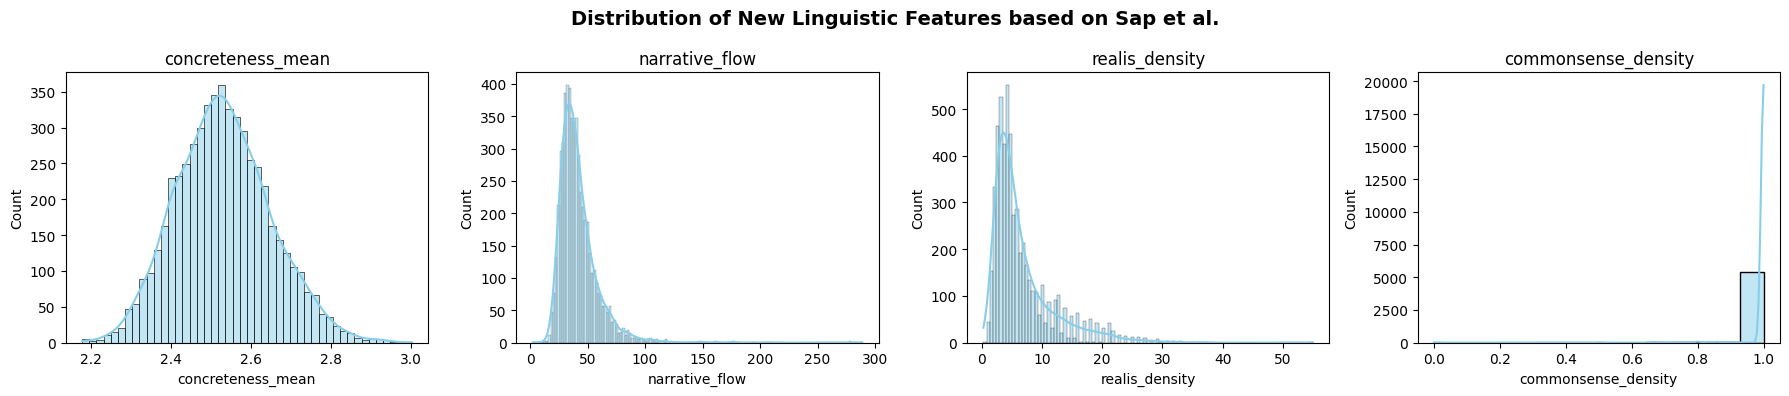

In [ ]:
# distributions
fig, axes = plt.subplots(1, len(new_feats), figsize=(18, 4))
for ax, feat in zip(axes, paper_feats):
    sns.histplot(df[feat].dropna(), kde=True, ax=ax, color="skyblue")
    ax.set_title(feat)
plt.suptitle("Distribution of New Linguistic Features based on Sap et al.", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

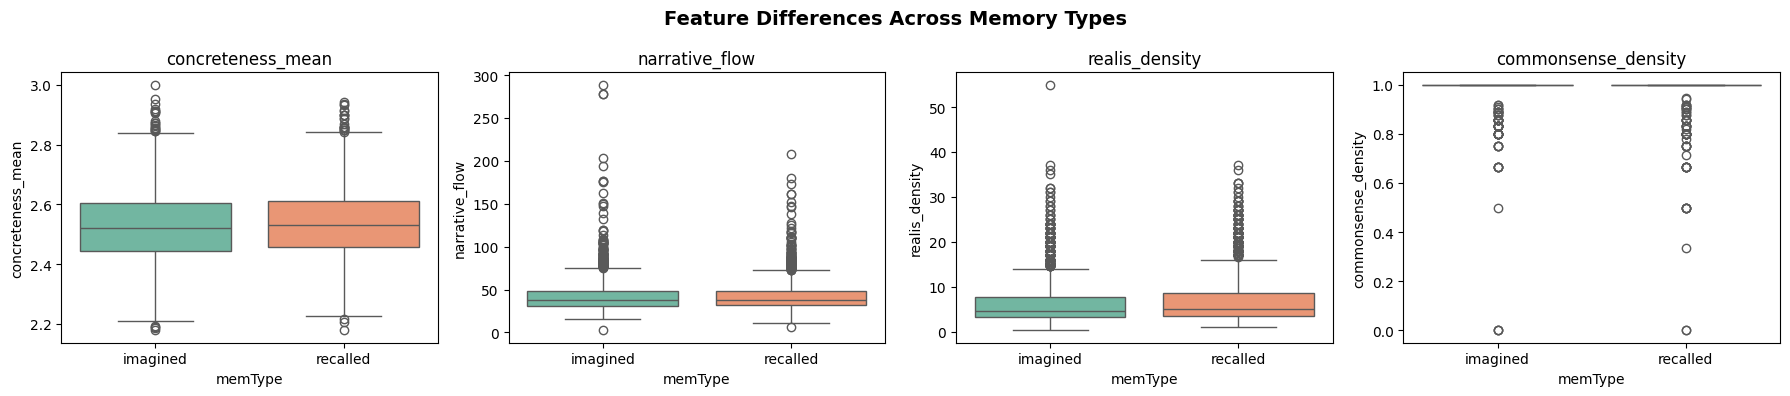

In [ ]:
# compare between recalled and imagined
fig, axes = plt.subplots(1, len(new_feats), figsize=(18, 4))
for ax, feat in zip(axes, paper_feats):
    sns.boxplot(data=df, x="memType", y=feat, hue="memType", palette="Set2", legend=False, ax=ax)
    ax.set_title(feat)

plt.suptitle("Feature Differences Across Memory Types", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

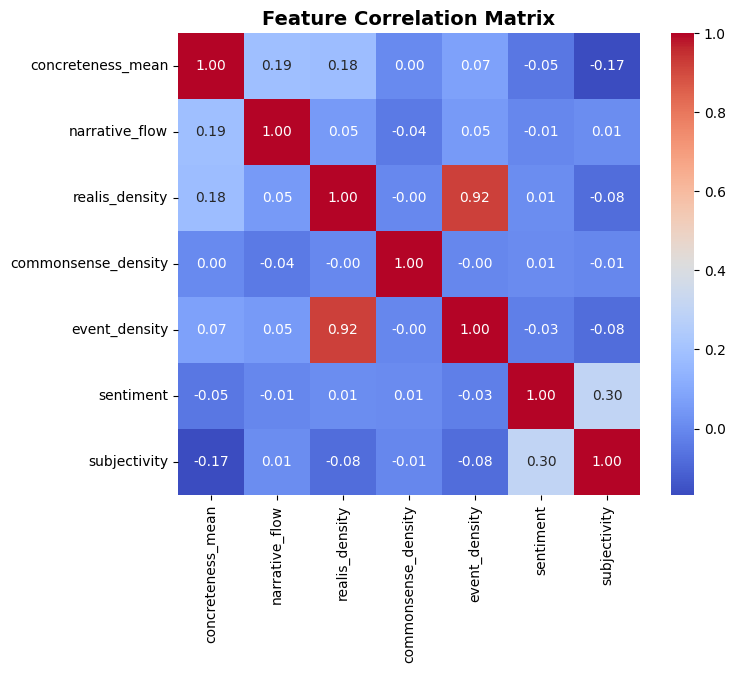

In [ ]:
# correlations
corr = df[paper_feats + ["sentiment", "subjectivity"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix", fontsize=14, weight="bold")
plt.show()

In [ ]:
# group means
print(df.groupby("memType")[paper_feats].mean().round(3))

          concreteness_mean  narrative_flow  realis_density  \
memType                                                       
imagined              2.527          42.188           6.299   
recalled              2.536          41.881           6.939   

          commonsense_density  event_density  
memType                                       
imagined                0.995         13.258  
recalled                0.995         14.983  


Correlation of new features with memType (1=imagined, 0=recalled):


,feature,r,p_value
1,narrative_flow,0.008650,0.519951
3,commonsense_density,0.007005,0.602324
0,concreteness_mean,-0.035870,0.007610
2,realis_density,-0.062981,0.000003
4,event_density,-0.078826,0.000000


/tmp/ipython-input-2525982181.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_df, x="r", y="feature", palette="coolwarm", orient="h")


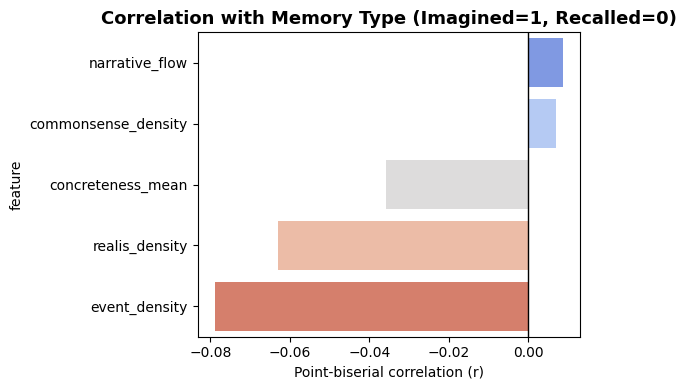

In [ ]:
## chek how well these features correlate with memtype and so how useful for my analysis
# Encode memtype to be numeric
df["memType_num"] = df["memType"].map({"imagined": 1, "recalled": 0})

# Compute point-biserial correlations
corrs = []
for feat in paper_feats:
    valid = df[[feat, "memType_num"]].dropna()
    r, p = pointbiserialr(valid["memType_num"], valid[feat])
    corrs.append({"feature": feat, "r": r, "p_value": p})

corr_df = pd.DataFrame(corrs).sort_values("r", ascending=False)

# Display correlation table ---
print("Correlation of new features with memType (1=imagined, 0=recalled):")
display(corr_df.style.background_gradient(subset=["r"], cmap="coolwarm", vmin=-1, vmax=1))

# Plot correlation strengths ---
plt.figure(figsize=(6,4))
sns.barplot(data=corr_df, x="r", y="feature", palette="coolwarm", orient="h")
plt.axvline(0, color="black", lw=1)
plt.title("Correlation with Memory Type (Imagined=1, Recalled=0)", fontsize=13, weight="bold")
plt.xlabel("Point-biserial correlation (r)")
plt.tight_layout()
plt.show()


In [ ]:
# save updated feature set as updated dataaset
# df.to_csv('updated_data2.csv', index=False)

#### Testing models using updated feature set

##### Features set up

In [ ]:
cp1features = ["modal","modal_rate","story_length","summary_length","first_person_rate","third_person_rate","sentiment","subjectivity"]
cp2features = ["concreteness_mean", "narrative_flow", "realis_density","commonsense_density", "event_density", "speculativeness", "n_emotions", "emotion_intensity", "syntactic_complexity"]
combined_feats = cp1features + cp2features

In [ ]:
use_feats = combined_feats
print(f"Using {len(use_feats)} features:", use_feats)

# set up data
X = df[use_feats].copy()
y = (df["memType"].astype(str).str.lower() == "imagined").astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Using 17 features: ['modal', 'modal_rate', 'story_length', 'summary_length', 'first_person_rate', 'third_person_rate', 'sentiment', 'subjectivity', 'concreteness_mean', 'narrative_flow', 'realis_density', 'commonsense_density', 'event_density', 'speculativeness', 'n_emotions', 'emotion_intensity', 'syntactic_complexity']


##### Logistic Regression Model


Accuracy: 0.623
F1 Score: 0.625
ROC-AUC : 0.678


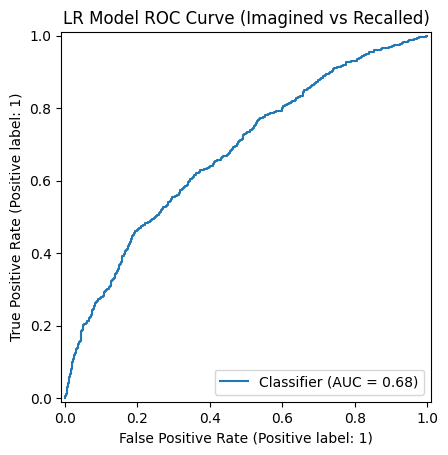


Feature Coefficients (positive ⇒ predicts 'imagined'):



,feature,coef
12,event_density,0.496018
13,speculativeness,0.416188
10,realis_density,0.293713
14,n_emotions,0.096760
6,sentiment,0.086453
0,modal,0.082044
1,modal_rate,0.074954
3,summary_length,0.074126
7,subjectivity,0.062604
15,emotion_intensity,0.049195


In [ ]:
# pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

# fit and predict
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

# get and show metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"\nAccuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC-AUC : {roc:.3f}")

# show ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("LR Model ROC Curve (Imagined vs Recalled)")
plt.show()

# coefficient Importance
lr = pipe.named_steps["clf"]
coef = lr.coef_.ravel()
coef_df = pd.DataFrame({
    "feature": use_feats,
    "coef": coef
}).sort_values("coef", ascending=False)

print("\nFeature Coefficients (positive ⇒ predicts 'imagined'):\n")
display(coef_df.style.background_gradient(cmap="coolwarm", vmin=-abs(coef).max(), vmax=abs(coef).max()))


##### Random Forst Classifier


Accuracy: 0.625
F1 Score: 0.611
ROC-AUC : 0.671


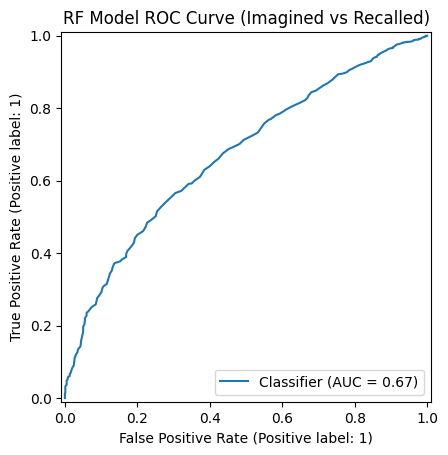


Feature Importances:



,feature,importance
2,story_length,0.098922
13,speculativeness,0.086667
4,first_person_rate,0.072416
15,emotion_intensity,0.068804
7,subjectivity,0.068262
9,narrative_flow,0.067574
8,concreteness_mean,0.066599
6,sentiment,0.065625
5,third_person_rate,0.063488
3,summary_length,0.061960


In [ ]:
# pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight="balanced",  # handles small imbalance if present
        n_jobs=-1
    ))
])

# fit and predict
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

# get and display metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"\nAccuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC-AUC : {roc:.3f}")

# show ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("RF Model ROC Curve (Imagined vs Recalled)")
plt.show()

# feature Importance
rf = pipe.named_steps["clf"]
importances = rf.feature_importances_
coef_df = pd.DataFrame({
    "feature": use_feats,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nFeature Importances:\n")
display(coef_df.style.background_gradient(cmap="YlOrRd"))


##### Same models on only cp1 features to comapre and show progress in writeup

In [ ]:
use_feats = cp1features
print(f"Using {len(use_feats)} features:", use_feats)

# set up data
X = df[use_feats].copy()
y = (df["memType"].astype(str).str.lower() == "imagined").astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Using 8 features: ['modal', 'modal_rate', 'story_length', 'summary_length', 'first_person_rate', 'third_person_rate', 'sentiment', 'subjectivity']



Accuracy: 0.597
F1 Score: 0.605
ROC-AUC : 0.633


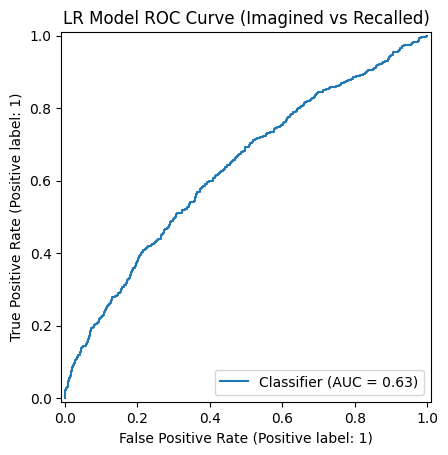


Feature Coefficients (positive ⇒ predicts 'imagined'):



,feature,coef
1,modal_rate,0.154721
4,first_person_rate,0.130424
7,subjectivity,0.083835
3,summary_length,0.064778
0,modal,0.052419
6,sentiment,0.004742
5,third_person_rate,0.004001
2,story_length,-0.405260


In [ ]:
# LR pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

# fit and predict
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

# get and show metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"\nAccuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC-AUC : {roc:.3f}")

# show ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("LR Model ROC Curve (Imagined vs Recalled)")
plt.show()

# coefficient Importance
lr = pipe.named_steps["clf"]
coef = lr.coef_.ravel()
coef_df = pd.DataFrame({
    "feature": use_feats,
    "coef": coef
}).sort_values("coef", ascending=False)

print("\nFeature Coefficients (positive ⇒ predicts 'imagined'):\n")
display(coef_df.style.background_gradient(cmap="coolwarm", vmin=-abs(coef).max(), vmax=abs(coef).max()))



Accuracy: 0.601
F1 Score: 0.583
ROC-AUC : 0.645


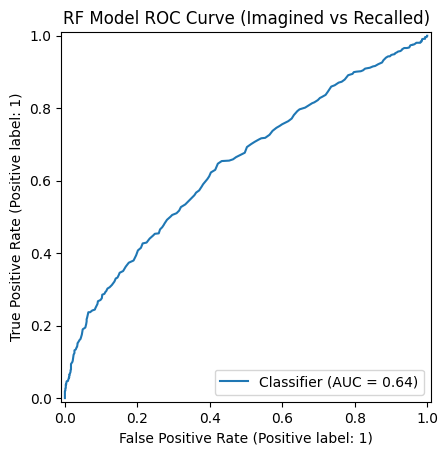


Feature Importances:



,feature,importance
2,story_length,0.164404
4,first_person_rate,0.144530
7,subjectivity,0.141519
6,sentiment,0.140012
5,third_person_rate,0.124346
1,modal_rate,0.120670
3,summary_length,0.115980
0,modal,0.048539


In [ ]:
# RF pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight="balanced",  # handles small imbalance if present
        n_jobs=-1
    ))
])

# fit and predict
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

# get and display metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"\nAccuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC-AUC : {roc:.3f}")

# show ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("RF Model ROC Curve (Imagined vs Recalled)")
plt.show()

# feature Importance
rf = pipe.named_steps["clf"]
importances = rf.feature_importances_
coef_df = pd.DataFrame({
    "feature": use_feats,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nFeature Importances:\n")
display(coef_df.style.background_gradient(cmap="YlOrRd"))
